In [1]:
import os
import json
import pyqg_subgrid_experiments as pse
import argparse
import time
import torch
import matplotlib.pyplot as plt
from pyqg_subgrid_experiments.models import ProbabilisticCNN
import xarray as xr
%load_ext autoreload
%autoreload 2

In [2]:
torch.cuda.is_available()

False

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--train_set', type=str, default="/scratch/zanna/data/pyqg/data/train/*.nc")
parser.add_argument('--test_set', type=str, default="/scratch/zanna/data/pyqg/data/test/*.nc")
parser.add_argument('--transfer_set', type=str, default="/scratch/zanna/data/pyqg/data/transfer/*.nc")
parser.add_argument('--save_dir', type=str, default="PCNN_var_0_0001_epoch_var_25")
parser.add_argument('--inputs', type=str, default="u,v,q")
parser.add_argument('--targets', type=str, default="q_forcing_advection")
parser.add_argument('--zero_mean', type=int, default=1)
parser.add_argument('--num_epochs', type=int, default=50)
parser.add_argument('--layerwise_inputs', type=int, default=0)
parser.add_argument('--layerwise_targets', type=int, default=0)

_StoreAction(option_strings=['--layerwise_targets'], dest='layerwise_targets', nargs=None, const=None, default=0, type=<class 'int'>, choices=None, help=None, metavar=None)

In [4]:
args = parser.parse_args("")

In [5]:
save_dir = args.save_dir
test_dir = os.path.join(save_dir, "test")
xfer_dir = os.path.join(save_dir, "transfer")
for d in [save_dir, test_dir, xfer_dir]:
    os.system(f"mkdir -p {d}") 

with open(f"{save_dir}/model_config.json", 'w') as f:
    f.write(json.dumps(args.__dict__))

In [6]:
test = pse.Dataset(args.test_set)
xfer = pse.Dataset(args.transfer_set)

In [7]:
train = pse.Dataset(args.train_set)

In [8]:
param = pse.CNNParameterization.train_on(train, save_dir,
            inputs=args.inputs.split(","),
            targets=args.targets.split(","),
            layerwise_inputs=False,
            layerwise_targets=True,
            zero_mean=args.zero_mean,
            model_class=ProbabilisticCNN,
            num_epochs=50,
            channel_type = 'var')

channel_type: var
self.channel_type: var
self.channel_type: var
self.channel_type: var
self.channel_type: var
model 0: var
model 1: var


In [9]:
test_result = param.test_offline(test, os.path.join(test_dir, "offline_metrics.nc"))

In [10]:
transfer_result = param.test_offline(xfer, os.path.join(xfer_dir, "offline_metrics.nc"))

In [11]:
test_var     = xr.open_dataset('VAR_CNN/test/offline_metrics.nc')
transfer_var = xr.open_dataset('VAR_CNN/transfer/offline_metrics.nc')

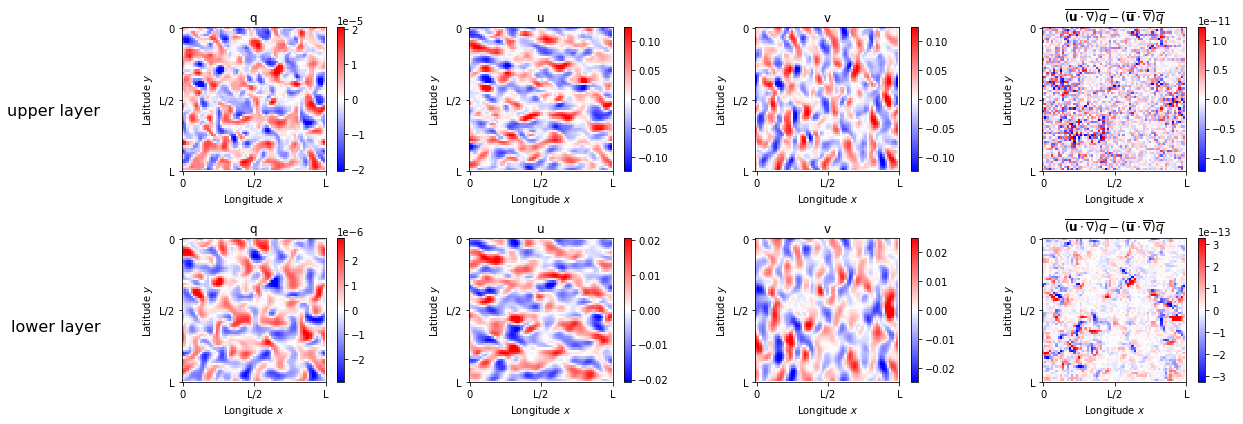

In [12]:
ds = train.isel(run=0,time=-1)
with pse.figure_grid(2,4) as g:
    g.fig.text(0, 0.75, 'upper layer', ha='right', va='top', fontsize=16)
    g.fig.text(0, 0.25, 'lower layer', ha='right', va='top', fontsize=16)
    g.next(); pse.imshow(ds.q.isel(lev=0), title='q')
    g.next(); pse.imshow(ds.u.isel(lev=0), title='u')
    g.next(); pse.imshow(ds.v.isel(lev=0), title='v')
    g.next(); pse.imshow(ds.q_forcing_advection.isel(lev=0), title=r'$\overline{(\mathbf{u} \cdot \nabla)q} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{q}$')
    
    g.next(); pse.imshow(ds.q.isel(lev=1), title='q')
    g.next(); pse.imshow(ds.u.isel(lev=1), title='u')
    g.next(); pse.imshow(ds.v.isel(lev=1), title='v')
    g.next(); pse.imshow(ds.q_forcing_advection.isel(lev=1), title=r'$\overline{(\mathbf{u} \cdot \nabla)q} - (\overline{\mathbf{u}} \cdot \overline{\nabla})\overline{q}$')
    

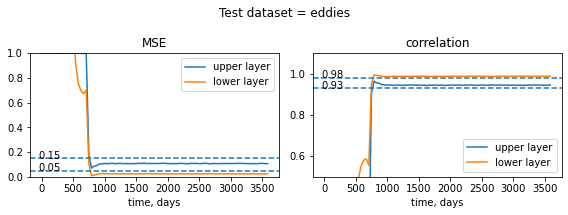

In [12]:
import numpy as np
ds = test_result
with pse.figure_grid(1,2) as g:
    g.title('Test dataset = eddies')
    time = ds.coords['time']
    if time.dtype == np.dtype('<m8[ns]'):
        time = (time.data / np.timedelta64(1, 'D')).astype(int)
    g.next(title="MSE")
    plt.plot(time,1-ds.q_forcing_advection_temporal_skill)
    plt.ylim([0,1])
    plt.legend(['upper layer', 'lower layer'])
    plt.xlabel('time, days')
    plt.axhline(y=0.05,linestyle='--')
    plt.text(x=-50,y=0.05,s='0.05')
    plt.axhline(y=0.15,linestyle='--')
    plt.text(x=-50,y=0.15,s='0.15')
    
    g.next(title="correlation")
    plt.plot(time,ds.q_forcing_advection_temporal_correlation)
    plt.ylim([0.5,1.1])
    plt.legend(['upper layer', 'lower layer'])
    plt.xlabel('time, days')
    plt.axhline(y=0.93,linestyle='--')
    plt.text(x=-50,y=0.93,s='0.93')
    plt.axhline(y=0.98,linestyle='--')
    plt.text(x=-50,y=0.98,s='0.98')

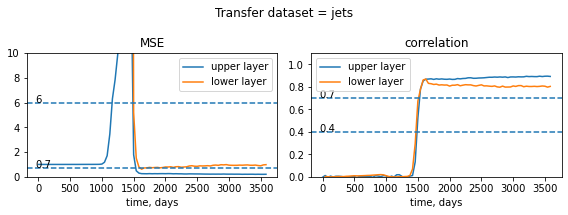

In [13]:
import numpy as np
ds = transfer_result
with pse.figure_grid(1,2) as g:
    g.title('Transfer dataset = jets')
    time = ds.coords['time']
    if time.dtype == np.dtype('<m8[ns]'):
        time = (time.data / np.timedelta64(1, 'D')).astype(int)
    g.next(title="MSE")
    plt.plot(time,1-ds.q_forcing_advection_temporal_skill)
    plt.ylim([0,10])
    plt.legend(['upper layer', 'lower layer'])
    plt.xlabel('time, days')
    plt.axhline(y=0.7,linestyle='--')
    plt.text(x=-50,y=0.7,s='0.7')
    plt.axhline(y=6,linestyle='--')
    plt.text(x=-50,y=6,s='6')
    
    g.next(title="correlation")
    plt.plot(time,ds.q_forcing_advection_temporal_correlation)
    plt.ylim([0.0,1.1])
    plt.legend(['upper layer', 'lower layer'])
    plt.xlabel('time, days')
    plt.axhline(y=0.4,linestyle='--')
    plt.text(x=-50,y=0.4,s='0.4')
    plt.axhline(y=0.7,linestyle='--')
    plt.text(x=-50,y=0.7,s='0.7')

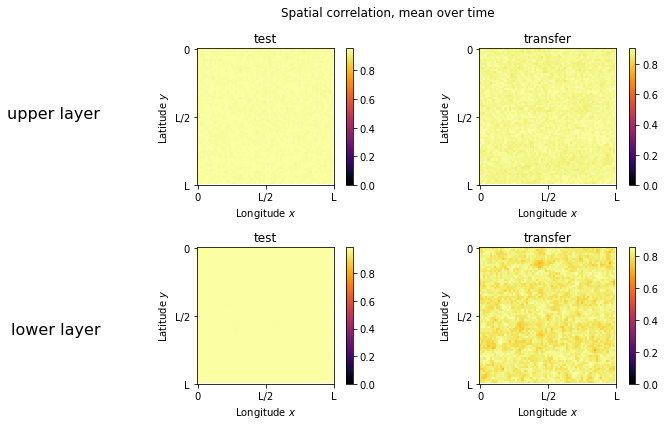

In [14]:
te = test_result
tr = transfer_result
with pse.figure_grid(2,2) as g:
    g.title('Spatial correlation, mean over time')
    g.fig.text(0, 0.75, 'upper layer', ha='right', va='top', fontsize=16)
    g.fig.text(0, 0.25, 'lower layer', ha='right', va='top', fontsize=16)
    g.next(); pse.imshow(te.q_forcing_advection_spatial_correlation.isel(lev=0), title='test')
    g.next(); pse.imshow(tr.q_forcing_advection_spatial_correlation.isel(lev=0), title='transfer')
    
    g.next(); pse.imshow(te.q_forcing_advection_spatial_correlation.isel(lev=1), title='test')
    g.next(); pse.imshow(tr.q_forcing_advection_spatial_correlation.isel(lev=1), title='transfer')
    

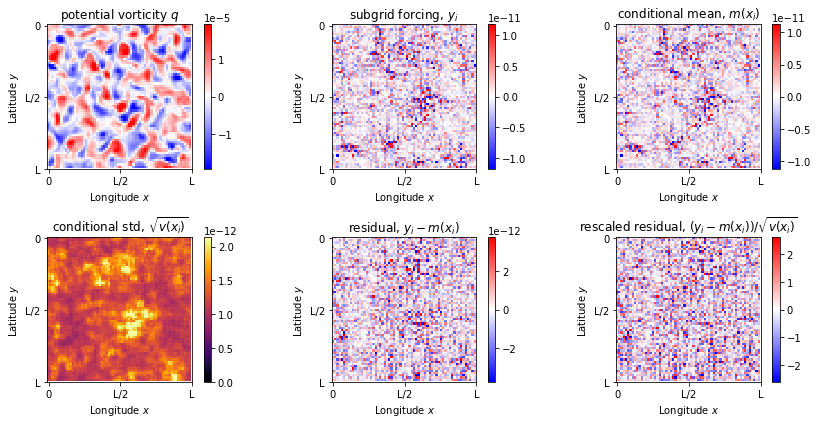

In [14]:
run = 0
time = -1
tt = test_result.isel(run=run,time=time)
q = test.q.isel(run=run,time=time,lev=0)
with pse.figure_grid(2,3) as g:
    g.next(); pse.imshow(q, title='potential vorticity $q$')
    g.next(); pse.imshow(tt.q_forcing_advection.isel(lev=0), title='subgrid forcing, $y_i$')
    g.next(); pse.imshow(tt.q_forcing_advection_predictions.isel(lev=0), title='conditional mean, $m(x_i)$')
    std = np.sqrt(tt.q_forcing_advection_var_predictions.isel(lev=0))
    residual = tt.q_forcing_advection.isel(lev=0) - tt.q_forcing_advection_predictions.isel(lev=0)
    g.next(); pse.imshow(std, title='conditional std, $\sqrt{v(x_i)}$')
    g.next(); pse.imshow(residual, title='residual, $y_i-m(x_i)$')
    g.next(); pse.imshow(residual/std, title='rescaled residual, $(y_i-m(x_i))/\sqrt{v(x_i)}$')

In [92]:
from scipy.stats import gaussian_kde
tt = test_result.isel(time = range(40,87), lev = 1)
residual = tt.q_forcing_advection - tt.q_forcing_advection_predictions
stds = np.sqrt(tt.q_forcing_advection_var_predictions)
residual_normalized = residual / stds
np.linalg.norm((residual_normalized*stds - residual).data.ravel())
print(residual_normalized.var().data)

0.7597132921218872


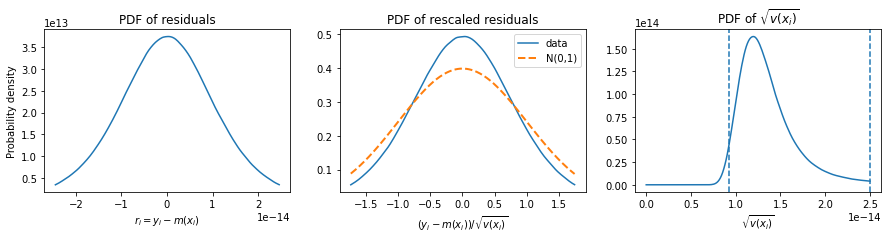

In [93]:
lim = 2.5
plt.figure(figsize=(15,3))
plt.subplot(131)
data = residual.data.ravel()
kde = gaussian_kde(data)
lo, hi = np.percentile(data, [lim, 100-lim])
lims = np.linspace(lo, hi, 200)
plt.plot(lims,kde(lims))
plt.xlabel('$r_i=y_i-m(x_i)$')
plt.ylabel('Probability density')
plt.title('PDF of residuals')
plt.subplot(132)
data = residual_normalized.data.ravel()
kde = gaussian_kde(data)
lo, hi = np.percentile(data, [lim, 100-lim])
lims = np.linspace(lo, hi, 200)
plt.plot(lims,kde(lims))
plt.plot(lims, 1/np.sqrt(2*np.pi) * np.exp(-0.5*np.square(lims)),'--',linewidth=2)
plt.legend(['data', 'N(0,1)'])
plt.xlabel('$(y_i-m(x_i))/\sqrt{v(x_i)}$')
plt.title('PDF of rescaled residuals')
plt.subplot(133)
data = stds.data.ravel()
kde = gaussian_kde(data)
lo, hi = np.percentile(data, [lim, 100-lim])
lims = np.linspace(0, hi, 200)
plt.plot(lims,kde(lims))
plt.xlabel('$\sqrt{v(x_i)}$')
plt.title('PDF of $\sqrt{v(x_i)}$')
plt.axvline(x=lo,linestyle='--')
plt.axvline(x=hi,linestyle='--')


[[1.         0.67547005]
 [0.67547005 1.        ]]


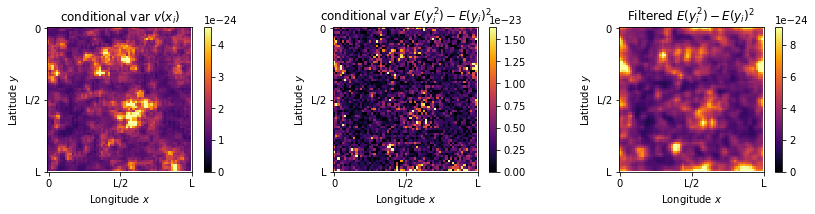

In [60]:
import numpy as np
import gcm_filters
run = 0
time = -1
tt = test_result.isel(run=run,time=time,lev=0)
tv = test_var.isel(run=run,time=time,lev=0)
real_filt = gcm_filters.Filter(filter_scale=4, dx_min=1)
with pse.figure_grid(1,3) as g:
    var = tt.q_forcing_advection_var_predictions
    g.next(); pse.imshow(var, title='conditional var $v(x_i)$')
    var = np.maximum(tv['mul(q_forcing_advection,q_forcing_advection)_predictions'].astype(np.float64) - np.square(tv.q_forcing_advection_predictions).astype(np.float64),0.)
    g.next(); pse.imshow(var, title='conditional var $E(y^2_i)-E(y_i)^2$')
    var2 = real_filt.apply(var, dims=['y','x'])
    g.next(); pse.imshow(real_filt.apply(var, dims=['y','x']), title='Filtered $E(y^2_i)-E(y_i)^2$')
    print(np.corrcoef(var.data.ravel(),var2.data.ravel()))

In [48]:
def KNN_search(dataset, snapshot):
    ntime = len(dataset.time)
    nrun = len(dataset.run)
    distance = np.zeros((nrun,ntime))
    
    for time in range(ntime):
        #print(f"time = {time}")
        for run in range(nrun):
            field = dataset.isel(run=run,time=time)
            distance[run,time] = np.linalg.norm(field.data.ravel() - snapshot.data.ravel())
            
    return distance

In [49]:
distance = KNN_search(train.q.isel(time=range(40,87)),test.q.isel(run=0,time=-1))

In [50]:
print(np.unravel_index(np.argmin(distance, axis=None), distance.shape))
print(distance.min())

(203, 24)
6.184287063237932e-04


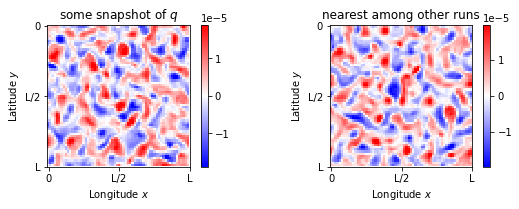

In [51]:
with pse.figure_grid(1,2) as g:
    g.next(); pse.imshow(test.q.isel(run=0,time=-1,lev=0), title = 'some snapshot of $q$')
    g.next(); pse.imshow(train.q.isel(run=203,time=24+40,lev=0), title='nearest among other runs')

In [14]:
field = test.q.isel(run=0,time=-1)
snapshot = train.q.isel(run=203,time=24+40)
x = np.linalg.norm(field.data.ravel() - snapshot.data.ravel())
print(np.array(x))

6.184287063237932e-04


[[1.        0.4467954]
 [0.4467954 1.       ]]


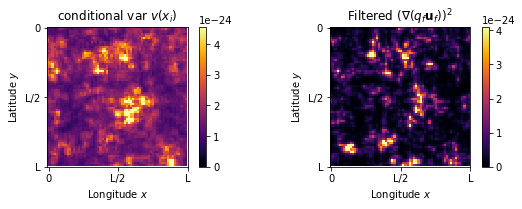

In [66]:
import numpy as np
import gcm_filters
run = 0
time = -1
tt = test_result.isel(run=run,time=time,lev=0)
t  = test.isel(run=run,time=time,lev=0)
real_filt = gcm_filters.Filter(filter_scale=2.5, dx_min=1)
with pse.figure_grid(1,2) as g:
    var = tt.q_forcing_advection_var_predictions
    g.next(); pse.imshow(var, title='conditional var $v(x_i)$')
    t.ds['qf'] = t.q - real_filt.apply(t.q, dims=['y','x'])
    t.ds['uf'] = t.u - real_filt.apply(t.u, dims=['y','x'])
    t.ds['vf'] = t.v - real_filt.apply(t.v, dims=['y','x'])
    t.ds['reynolds'] = t.extract_feature('div(mul(qf,uf),mul(qf,vf))')
    t.ds['reynolds2'] = t.extract_feature('mul(reynolds,reynolds)')
    var2 = real_filt.apply(t.reynolds2, dims=['y','x'])
    g.next(); pse.imshow(var2, title=r'Filtered $(\nabla (q_f \mathbf{u}_f))^2$')
    #print(type(t))
    print(np.array(np.corrcoef(var.data.ravel(),var2.data.ravel())))

[[1.         0.46189044]
 [0.46189044 1.        ]]


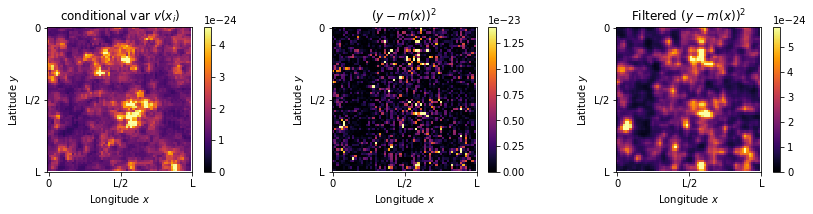

In [61]:
import numpy as np
import gcm_filters
run = 0
time = -1
tt = test_result.isel(run=run,time=time,lev=0)
t  = test.isel(run=run,time=time,lev=0)
real_filt = gcm_filters.Filter(filter_scale=4, dx_min=1)
with pse.figure_grid(1,3) as g:
    var = tt.q_forcing_advection_var_predictions
    g.next(); pse.imshow(var, title='conditional var $v(x_i)$')
    residual = tt.q_forcing_advection - tt.q_forcing_advection_predictions
    res2 = np.square(residual)
    g.next(); pse.imshow(res2, title='$(y-m(x))^2$')
    var2 = real_filt.apply(res2, dims=['y','x'])
    g.next(); pse.imshow(var2, title='Filtered $(y-m(x))^2$')
    print(np.corrcoef(var.data.ravel(),var2.data.ravel()))

[[1.         0.50160895]
 [0.50160895 1.        ]]


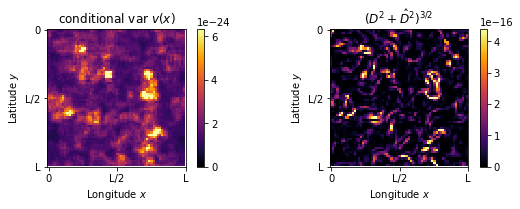

In [68]:
import numpy as np
run = 5
time = -1
tt = test_result.isel(run=run,time=time,lev=0)
t  = test.isel(run=run,time=time,lev=0)
real_filt = gcm_filters.Filter(filter_scale=3, dx_min=1)
with pse.figure_grid(1,2) as g:
    var = tt.q_forcing_advection_var_predictions
    g.next(); pse.imshow(var, title='conditional var $v(x)$') 
    var2 = np.power(t.stretching_deformation**2+t.shearing_deformation**2,1.5)
    g.next(); pse.imshow(var2, title='$(D^2+\hat{D}^2)^{3/2}$')
    print(np.array(np.corrcoef(var.data.ravel(),var2.data.ravel())))

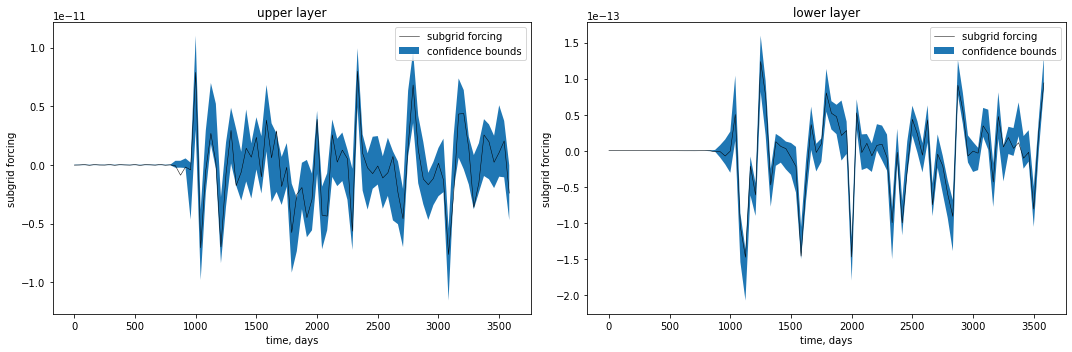

In [69]:
import numpy as np
tt = test_result.isel(run=0,x=0,y=0)
with pse.figure_grid(1,2) as g:
    g.fig.set_figheight(5)
    g.fig.set_figwidth(15)
    time = tt.coords['time']
    if time.dtype == np.dtype('<m8[ns]'):
        time = (time.data / np.timedelta64(1, 'D')).astype(int)
    truth = tt.q_forcing_advection.isel(lev=0)
    mean = tt.q_forcing_advection_predictions.isel(lev=0)
    std = np.sqrt(tt.q_forcing_advection_var_predictions.isel(lev=0))
    bounds = [mean-1.96*std,mean+1.96*std]
    g.next();
    plt.plot(time, truth, 'k', linewidth=0.5)
    plt.fill_between(time,*bounds)
    plt.xlabel('time, days')
    plt.ylabel('subgrid forcing')
    plt.title('upper layer')
    plt.legend(['subgrid forcing', 'confidence bounds'])
    
    time = tt.coords['time']
    if time.dtype == np.dtype('<m8[ns]'):
        time = (time.data / np.timedelta64(1, 'D')).astype(int)
    truth = tt.q_forcing_advection.isel(lev=1)
    mean = tt.q_forcing_advection_predictions.isel(lev=1)
    std = np.sqrt(tt.q_forcing_advection_var_predictions.isel(lev=1))
    bounds = [mean-1.96*std,mean+1.96*std]
    g.next();
    plt.plot(time, truth, 'k', linewidth=0.5)
    plt.fill_between(time,*bounds)
    plt.xlabel('time, days')
    plt.ylabel('subgrid forcing')
    plt.title('lower layer')
    plt.legend(['subgrid forcing', 'confidence bounds'])

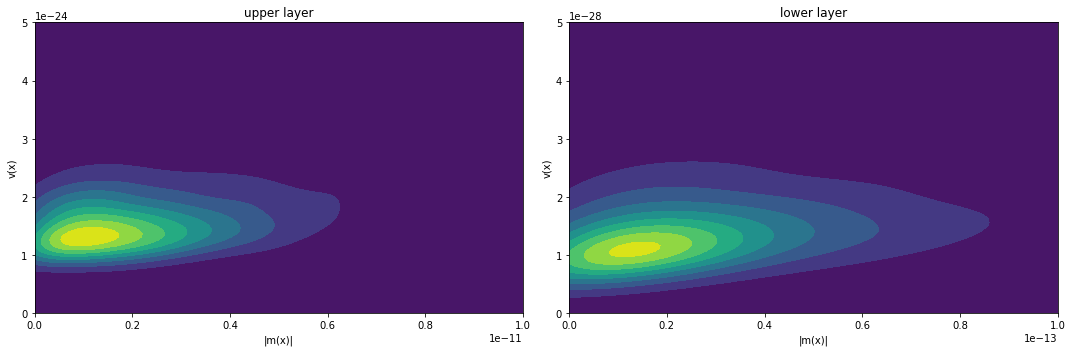

In [75]:
import numpy as np
import scipy.stats as st
tt = test_result.isel(run=range(1), time=-1)
with pse.figure_grid(1,2) as g:
    g.fig.set_figheight(5)
    g.fig.set_figwidth(15)
    g.next();
    m = np.abs(tt.q_forcing_advection_predictions.isel(lev=0).data)
    v = tt.q_forcing_advection_var_predictions.isel(lev=0).data
    
    xmin = 0 
    xmax = 1e-11
    ymin = 0
    ymax = 5e-24
    
    kernel = st.gaussian_kde(np.vstack([m.ravel(),v.ravel()]))
    xx,yy = np.meshgrid(np.linspace(0,xmax,100),np.linspace(0,ymax,100))
    positions = np.vstack([xx.ravel(),yy.ravel()])
    zz = np.reshape(kernel(positions).T,xx.shape)
    #plt.plot(m.ravel(),v.ravel(),'.')
    plt.contourf(xx,yy,zz,10)
    #plt.xlim([0,1])
    plt.xlabel('|m(x)|')
    plt.ylabel('v(x)')
    plt.title('upper layer')
    
    g.next();
    m = np.abs(tt.q_forcing_advection_predictions.isel(lev=1).data)
    v = tt.q_forcing_advection_var_predictions.isel(lev=1).data
    
    xmin = 0 
    xmax = 1e-13
    ymin = 0
    ymax = 5e-28
    
    kernel = st.gaussian_kde(np.vstack([m.ravel(),v.ravel()]))
    xx,yy = np.meshgrid(np.linspace(0,xmax,100),np.linspace(0,ymax,100))
    positions = np.vstack([xx.ravel(),yy.ravel()])
    zz = np.reshape(kernel(positions).T,xx.shape)
    plt.contourf(xx,yy,zz,10)
    plt.xlabel('|m(x)|')
    plt.ylabel('v(x)')
    plt.title('lower layer')
    

Corr coeff =  [[ 1.         -0.07492618]
 [-0.07492618  1.        ]]


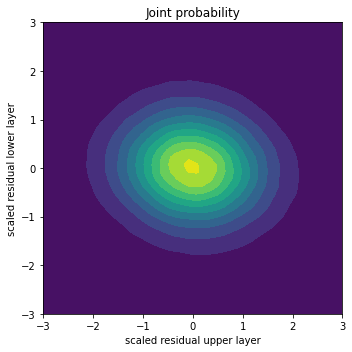

In [121]:
import numpy as np
import scipy.stats as st
tt = test_result.isel(run=range(25), time=range(-10,-1))
with pse.figure_grid(1,1) as g:
    g.fig.set_figheight(5)
    g.fig.set_figwidth(5)
    g.next();
    residual = (tt.q_forcing_advection - tt.q_forcing_advection_predictions) / np.sqrt(tt.q_forcing_advection_var_predictions)
    
    res0 = residual.isel(lev=0).data.ravel()
    res1 = residual.isel(lev=1).data.ravel()
    
    #np.random.shuffle(res1)
    
    print('Corr coeff = ', np.corrcoef(res0,res1))
    
    xmax = np.abs(res0).max()
    ymax = np.abs(res1).max()

    kernel = st.gaussian_kde(np.vstack([res0,res1]))
    xx,yy = np.meshgrid(np.linspace(-xmax,xmax,100),np.linspace(-ymax,ymax,100))
    positions = np.vstack([xx.ravel(),yy.ravel()])
    zz = np.reshape(kernel(positions).T,xx.shape)
    plt.contourf(xx,yy,zz,10)
    plt.xlabel('scaled residual upper layer')
    plt.ylabel('scaled residual lower layer')
    plt.title('Joint probability')
    plt.xlim([-3,3])
    plt.ylim([-3,3])

In [117]:
tt = test_result
residual = (tt.q_forcing_advection - tt.q_forcing_advection_predictions) / np.sqrt(tt.q_forcing_advection_var_predictions)
res0 = residual.isel(lev=0).data.ravel()
res1 = residual.isel(lev=1).data.ravel()
#np.random.shuffle(res1)
    
print('Corr coeff = ', np.corrcoef(res0,res1))

Corr coeff =  [[ 1.        -0.0594381]
 [-0.0594381  1.       ]]


Number of bins = 80, over the interval (-4,4), with bandwidth = 0.1
This interval covers 0.999931 of total probability


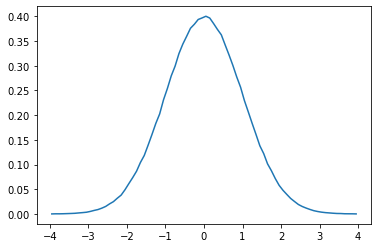

In [413]:
from pyqg_subgrid_experiments.plot_helpers import PDF_histogram
x = np.random.randn(1000000,1) 
density, points = PDF_histogram(x, xmin=-4, xmax=4, bandwidth=0.1)
plt.plot(points,density)

Number of bins = 50, over the interval (-1e-11,1e-11), with bandwidth = 3.9999999999999996e-13
This interval covers 0.9713100482047873 of total probability
Number of bins = 50, over the interval (-1e-11,1e-11), with bandwidth = 3.9999999999999996e-13
This interval covers 0.9771361785239362 of total probability
Number of bins = 50, over the interval (-1e-11,1e-11), with bandwidth = 3.9999999999999996e-13
This interval covers 0.9729336353058511 of total probability
Number of bins = 50, over the interval (-1e-13,1e-13), with bandwidth = 4e-15
This interval covers 0.864312458444149 of total probability
Number of bins = 50, over the interval (-1e-13,1e-13), with bandwidth = 4e-15
This interval covers 0.8671619431515958 of total probability
Number of bins = 50, over the interval (-1e-13,1e-13), with bandwidth = 4e-15
This interval covers 0.8628947805851064 of total probability


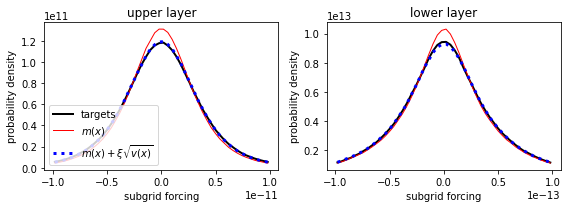

In [15]:
from pyqg_subgrid_experiments.plot_helpers import PDF_histogram

tt = test_result.isel(time=range(40,87))
with pse.figure_grid(1,2) as g:
    g.next();
    lev, xmin, xmax, Nbins = 0, -1e-11, 1e-11, 50
    
    true = tt.q_forcing_advection.isel(lev=lev)
    mean = tt.q_forcing_advection_predictions.isel(lev=lev)
    var = tt.q_forcing_advection_var_predictions.isel(lev=lev)
    prediction = mean + np.random.randn(*mean.shape) * np.sqrt(var)
    
    density, points = PDF_histogram(true.data.ravel(),xmin=xmin,xmax=xmax,Nbins=Nbins)
    plt.plot(points, density, 'k', linewidth = 2)
    density, points = PDF_histogram(mean.data.ravel(),xmin=xmin,xmax=xmax,Nbins=Nbins)
    plt.plot(points, density, 'r', linewidth = 1)
    density, points = PDF_histogram(prediction.data.ravel(),xmin=xmin,xmax=xmax,Nbins=Nbins)
    plt.plot(points, density, ':b', linewidth = 3)
    plt.legend(['targets', r'$m(x)$', r'$m(x)+\xi \sqrt{v(x)}$'], loc = 'lower left')
    plt.xlabel('subgrid forcing')
    plt.ylabel('probability density')
    plt.title('upper layer')
    
    g.next();
    lev, xmin, xmax, Nbins = 1, -1e-13, 1e-13, 50
    
    true = tt.q_forcing_advection.isel(lev=lev)
    mean = tt.q_forcing_advection_predictions.isel(lev=lev)
    var = tt.q_forcing_advection_var_predictions.isel(lev=lev)
    prediction = mean + np.random.randn(*mean.shape) * np.sqrt(var)
    
    density, points = PDF_histogram(true.data.ravel(),xmin=xmin,xmax=xmax,Nbins=Nbins)
    plt.plot(points, density, 'k', linewidth = 2)
    density, points = PDF_histogram(mean.data.ravel(),xmin=xmin,xmax=xmax,Nbins=Nbins)
    plt.plot(points, density, 'r', linewidth = 1)
    density, points = PDF_histogram(prediction.data.ravel(),xmin=xmin,xmax=xmax,Nbins=Nbins)
    plt.plot(points, density, ':b', linewidth = 3)
    #plt.legend(['targets', r'$m(x)$', r'$m(x)+\xi \sqrt{v(x)}$'])
    plt.xlabel('subgrid forcing')
    plt.ylabel('probability density')
    plt.title('lower layer')

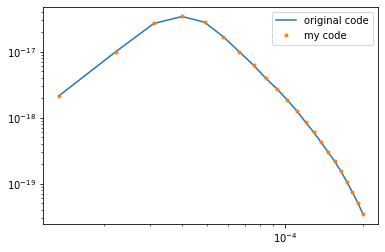

In [171]:
k, spec = test.isotropic_spectrum('Ensspec', z='sum')
plt.loglog(k, spec)
k, spec = test.isotropic_spectrum_compute(test.q.isel(time=range(40,87)), z='sum')
plt.loglog(k, spec, '.')
plt.legend(['original code', 'my code'])